In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# defining our device, 'cuda:0' if CUDA is available, 'cpu' otherwise
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
# make the transform pipeline, converting to tensor and normalizing
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# the batch size during training
batch_size = 64

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, 
                                             download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, 
                                             download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                           shuffle=False, num_workers=2)

Files already downloaded and verified


In [ ]:
# the MNIST classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
# switch to GPU if available
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
import torch.optim as optim

# defining the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def get_test_loss(net, criterion, data_loader):
  """A simple function that iterates over `data_loader` to calculate the overall loss"""
  testing_loss = []
  with torch.no_grad():
    for data in data_loader:
      inputs, labels = data
      # get the data to GPU (if available)
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = net(inputs)
      # calculate the loss for this batch
      loss = criterion(outputs, labels)
      # add the loss of this batch to the list
      testing_loss.append(loss.item())
  # calculate the average loss
  return sum(testing_loss) / len(testing_loss)

In [ ]:
training_loss, testing_loss = [], []
running_loss = []
i = 0
for epoch in range(150): # 150 epochs
  for data in train_loader:
    inputs, labels = data
    # get the data to GPU (if available)
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    # forward pass
    outputs = net(inputs)
    # backward pass
    loss = criterion(outputs, labels)
    loss.backward()
    # update gradients
    optimizer.step()
    running_loss.append(loss.item())
    i += 1
    if i % 1000 == 0:
      avg_train_loss = sum(running_loss) / len(running_loss)
      avg_test_loss = get_test_loss(net, criterion, test_loader)
      # clear the list
      running_loss.clear()
      # for logging & plotting later
      training_loss.append(avg_train_loss)
      testing_loss.append(avg_test_loss)
      print(f"[{epoch:2d}] [it={i:5d}] Train Loss: {avg_train_loss:.3f}, Test Loss: {avg_test_loss:.3f}")

  
print("Done training.")

[ 1] [it= 1000] Train Loss: 2.298, Test Loss: 2.280
[ 2] [it= 2000] Train Loss: 2.087, Test Loss: 1.907
[ 3] [it= 3000] Train Loss: 1.785, Test Loss: 1.685
[ 5] [it= 4000] Train Loss: 1.631, Test Loss: 1.574
[ 6] [it= 5000] Train Loss: 1.529, Test Loss: 1.484
[ 7] [it= 6000] Train Loss: 1.449, Test Loss: 1.421
[ 8] [it= 7000] Train Loss: 1.392, Test Loss: 1.373
[10] [it= 8000] Train Loss: 1.329, Test Loss: 1.316
[11] [it= 9000] Train Loss: 1.276, Test Loss: 1.279
[12] [it=10000] Train Loss: 1.236, Test Loss: 1.232
[14] [it=11000] Train Loss: 1.188, Test Loss: 1.194
[15] [it=12000] Train Loss: 1.139, Test Loss: 1.202
[16] [it=13000] Train Loss: 1.111, Test Loss: 1.157
[17] [it=14000] Train Loss: 1.081, Test Loss: 1.151
[19] [it=15000] Train Loss: 1.049, Test Loss: 1.112
[20] [it=16000] Train Loss: 1.019, Test Loss: 1.116
[21] [it=17000] Train Loss: 1.003, Test Loss: 1.115
[23] [it=18000] Train Loss: 0.974, Test Loss: 1.048
[24] [it=19000] Train Loss: 0.949, Test Loss: 1.037
[25] [it=200

In [ ]:
class NetDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.do1 = nn.Dropout(0.2)  # 20% Probability
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.do2 = nn.Dropout(0.2)  # 20% Probability
        self.fc2 = nn.Linear(120, 84)
        self.do3 = nn.Dropout(0.1)  # 10% Probability
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.do1(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.do2(x)
        x = F.relu(self.fc2(x))
        x = self.do3(x)
        x = self.fc3(x)
        return x


net_dropout = NetDropout()
net_dropout.to(device)

NetDropout(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (do1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (do2): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (do3): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_dropout.parameters(), lr=0.001, momentum=0.9)

In [ ]:
training_loss_d, testing_loss_d = [], []
running_loss = []
i = 0
for epoch in range(150): # 10 epochs
  for data in train_loader:
    inputs, labels = data
    # get the data to GPU (if available)
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    # forward pass
    outputs = net_dropout(inputs)
    # backward pass
    loss = criterion(outputs, labels)
    loss.backward()
    # update gradients
    optimizer.step()
    running_loss.append(loss.item())
    i += 1
    if i % 1000 == 0:
      avg_train_loss = sum(running_loss) / len(running_loss)
      avg_test_loss = get_test_loss(net_dropout, criterion, test_loader)
      # clear the list
      running_loss.clear()
      # for logging & plotting later
      training_loss_d.append(avg_train_loss)
      testing_loss_d.append(avg_test_loss)
      print(f"[{epoch:2d}] [it={i:5d}] Train Loss: {avg_train_loss:.3f}, Test Loss: {avg_test_loss:.3f}")

  
print("Done training.")

[ 1] [it= 1000] Train Loss: 2.296, Test Loss: 2.270
[ 2] [it= 2000] Train Loss: 2.113, Test Loss: 1.992
[ 3] [it= 3000] Train Loss: 1.910, Test Loss: 1.810
[ 5] [it= 4000] Train Loss: 1.757, Test Loss: 1.680
[ 6] [it= 5000] Train Loss: 1.660, Test Loss: 1.607
[ 7] [it= 6000] Train Loss: 1.587, Test Loss: 1.563
[ 8] [it= 7000] Train Loss: 1.535, Test Loss: 1.499
[10] [it= 8000] Train Loss: 1.488, Test Loss: 1.481
[11] [it= 9000] Train Loss: 1.455, Test Loss: 1.441
[12] [it=10000] Train Loss: 1.426, Test Loss: 1.412
[14] [it=11000] Train Loss: 1.400, Test Loss: 1.394
[15] [it=12000] Train Loss: 1.377, Test Loss: 1.365
[16] [it=13000] Train Loss: 1.350, Test Loss: 1.341
[17] [it=14000] Train Loss: 1.332, Test Loss: 1.324
[19] [it=15000] Train Loss: 1.311, Test Loss: 1.325
[20] [it=16000] Train Loss: 1.289, Test Loss: 1.309
[21] [it=17000] Train Loss: 1.264, Test Loss: 1.280
[23] [it=18000] Train Loss: 1.255, Test Loss: 1.290
[24] [it=19000] Train Loss: 1.238, Test Loss: 1.255
[25] [it=200

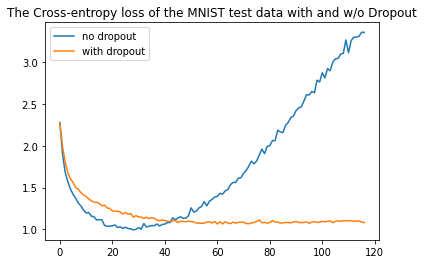

In [16]:
import matplotlib.pyplot as plt

# plot both benchmarks
plt.plot(testing_loss, label="no dropout")
plt.plot(testing_loss_d, label="with dropout")
# make the legend on the plot
plt.legend()
plt.title("The Cross-entropy loss of the MNIST test data with and w/o Dropout")
plt.show()

In [15]:
import time

while True:
  time.sleep(30)

KeyboardInterrupt: ignored